### Ship-iceberg clsiification from satellite radar images

A simple convolutional neural network is used to classify ship/iceberg from radar satellite images. The network is found to produce an accuracy of 87%. The model was developed using the previous version of tensorflow.

In [15]:
import math
import json
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from scipy import io
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
from tqdm import tqdm 

%matplotlib inline

The original data was converted to NumPy array first. 

In [ ]:
train_data = np.load('train_data.npy')
test_data=np.load('test_data.npy')
num=155
print(train_data.shape) #check

All of the images are greyscale; however,each image has values from 2 channels (band_1 and band_2). Some images contain the incident angle of the satellite, which is passed as a separate parameter forthe dataset

In [ ]:

IMG_SIZE=75
X_train_orig=np.empty([len(train_data),IMG_SIZE,IMG_SIZE,2])
X_train_orig_lin=np.empty([len(train_data),IMG_SIZE,IMG_SIZE,2])
Y_train_orig=np.empty([len(train_data),1])
X_test_orig=np.empty([len(test_data),IMG_SIZE,IMG_SIZE,2])


for i in range(len(train_data)):
    X_train_orig[i,:,:,0]=np.asarray(train_data[i]['band_1']).reshape(IMG_SIZE,IMG_SIZE)
    X_train_orig[i,:,:,1]=np.asarray(train_data[i]['band_2']).reshape(IMG_SIZE,IMG_SIZE)
    Y_train_orig[i,0]=np.asarray(train_data[i]['is_iceberg']).reshape(1,1)
    X_train_orig_lin[i,:,:,0]=np.power(10,X_train_orig[i,:,:,0]/10)
    X_train_orig_lin[i,:,:,1]=np.power(10,X_train_orig[i,:,:,1]/10)
    if train_data[i]['inc_angle']!='na':
        if np.asarray(train_data[i]['inc_angle'])<30:
            mean=np.mean(X_train_orig_lin[i,:,:,1])
            std_dev=np.std(X_train_orig_lin[i,:,:,1])
            threshold=mean+0.8*std_dev
            ind_mat=X_train_orig_lin[i,:,:,1]>threshold
        else:
            mean=np.mean(X_train_orig_lin[i,:,:,0])
            std_dev=np.std(X_train_orig_lin[i,:,:,0])
            threshold=mean+0.8*std_dev
            ind_mat=X_train_orig_lin[i,:,:,0]>threshold
    else:
        mean=np.mean(X_train_orig_lin[i,:,:,0])
        std_dev=np.std(X_train_orig_lin[i,:,:,0])
        threshold=mean+0.8*std_dev
        ind_mat=X_train_orig_lin[i,:,:,0]>threshold
            
    X_train_orig[i,:,:,0]=np.multiply(X_train_orig[i,:,:,0],ind_mat)
    X_train_orig[i,:,:,1]=np.multiply(X_train_orig[i,:,:,1],ind_mat)
            
    #    if np.asarray(train_data[i]['inc_angle'])<30:
    #        X_train_orig[i,:,:,0]=X_train_orig[i,:,:,0]*5
    #    else:
    #        X_train_orig[i,:,:,1]=X_train_orig[i,:,:,1]*5


Y_train_orig=np.int_(Y_train_orig.reshape(1604,1))

for i in range(len(test_data)):
    X_test_orig[i,:,:,0]=np.asarray(test_data[i]['band_1']).reshape(IMG_SIZE,IMG_SIZE)
    X_test_orig[i,:,:,1]=np.asarray(test_data[i]['band_2']).reshape(IMG_SIZE,IMG_SIZE)
a=np.arange(X_train_orig.shape[0])

np.random.shuffle(a)
print(a.shape[0])
train_ind=1400
X_train=X_train_orig[a[0:train_ind]]
Y_train=Y_train_orig[a[0:train_ind]]


X_test=X_train_orig[a[train_ind:1604]]
Y_test=Y_train_orig[a[train_ind:1604]]

Y_train = convert_to_one_hot(Y_train, 2).T
Y_test = convert_to_one_hot(Y_test, 2).T

print(Y_train.shape,X_train.shape,X_test_orig.shape)

Visualization of a sample image

30.4878
[1]
-0.4427015632 0.0182635708538
[[-0. -0. -0. ..., -0. -0. -0.]
 [-0. -0. -0. ..., -0. -0. -0.]
 [-0. -0. -0. ..., -0. -0. -0.]
 ..., 
 [-0. -0. -0. ..., -0. -0. -0.]
 [-0. -0. -0. ..., -0. -0. -0.]
 [-0. -0. -0. ..., -0. -0. -0.]]


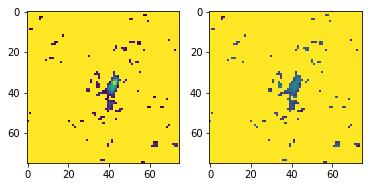

In [21]:
id=530
print(train_data[id]['inc_angle'])
print(Y_train_orig[id])
x1=X_train_orig[id,:,:,0]

fig, axarr = plt.subplots(1, 2)
print(np.mean(X_train_orig[id,:,:,0]),np.mean(X_train_orig_lin[id,:,:,0]))
axarr[0].imshow(X_train_orig[id,:,:,0])
axarr[1].imshow(X_train_orig[id,:,:,1])
print(X_train_orig[id,:,:,0])

Training the neural network

In [28]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected, flatten, one_hot_encoding
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation


# Create extra synthetic training data by flipping, rotating and blurring the
# images on our data set.
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)
img_aug.add_random_blur(sigma_max=3.)

tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 2], data_augmentation=img_aug, name='input')

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3, padding ='valid')

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = flatten(convnet)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.9)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=1e-3, loss='categorical_crossentropy',name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

model.fit({'input': X_train}, {'targets': Y_train}, n_epoch=50, validation_set=({'input': X_test}, {'targets': Y_test}), 
    snapshot_step=500, show_metric=True)

Training Step: 1099  | total loss: 0.35328 | time: 6.076s
| Adam | epoch: 050 | loss: 0.35328 - acc: 0.8580 -- iter: 1344/1400
Training Step: 1100  | total loss: 0.34434 | time: 7.361s
| Adam | epoch: 050 | loss: 0.34434 - acc: 0.8613 | val_loss: 0.38006 - val_acc: 0.8284 -- iter: 1400/1400
--


Model prediction

In [ ]:
model_out = model.predict(X_test_orig)
#prediction=np.empty([100,1])
ind=3500
prediction=model_out[:,1]

print(model_out[ind],prediction[ind])